# Initialize Notebook
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [52]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits import mplot3d
from matplotlib import rcParams
import matplotlib.colors as colors
import copy
import math
import sys
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from tqdm import tqdm
import os
# %matplotlib qt
%matplotlib inline

In [53]:
sys.path.append("../Analytical-Meridional-Non-Paraxial-Ray-Propagation")
from Src import *

In [54]:
sys.path.append("../python")
import plotParameters

# Define Functions
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [4]:
def constructOpticalSystem(lens_parameters, verbose=False):
    """
    Construct the optical system from the specified parameters.
    """
    surfaces = []
    lenses   = []
    for nLens in range(len(lens_parameters)):
        if nLens != len(lens_parameters)-1:
            surfaces.append(surface(lens_parameters[nLens][0][0],lens_parameters[nLens][0][1],
                                    lens_parameters[nLens][4] - lens_parameters[nLens][0][0] - lens_parameters[nLens][1]/2,
                                    lens_parameters[nLens][0][2],lens_parameters[nLens][0][3],verbose=verbose))
            surfaces.append(surface(lens_parameters[nLens][3][0],lens_parameters[nLens][3][1],
                                    lens_parameters[nLens][4] - lens_parameters[nLens][3][0] + lens_parameters[nLens][1]/2,
                                    lens_parameters[nLens][3][2],lens_parameters[nLens][3][3],verbose=verbose))
            lenses.append(lens(surfaces[-2],surfaces[-1],lens_parameters[nLens][2],verbose)) 
        else:
            surfaces.append(surface(lens_parameters[nLens][0][0],lens_parameters[nLens][0][1],lens_parameters[nLens][0][2],
                                    lens_parameters[nLens][0][3],lens_parameters[nLens][0][4],verbose=verbose))
    OS = opticalSystem(lenses,surfaces[-1],lens_parameters[-1][1],verbose)
    return surfaces, lenses, OS

In [5]:
def getBackPoints(lens_parameters, OS, r, y_lim, theta_lim, nFrames):
    backPlanePoints = []
    for nFrame in range(nFrames):
        nFrame_theta = nFrame // y_lim[2]
        nFrame_y     = nFrame - nFrame_theta * y_lim[2]

        theta      = theta_lim[0] + ( theta_lim[1] - theta_lim[0] ) / (theta_lim[2]-1) * nFrame_theta
        y          = y_lim[0] + (y_lim[1] - y_lim[0])/(y_lim[2]-1)*nFrame_y
        OR         = opticalRay(r,y,theta)
        RP         = rayPropagator(OS,OR,lens_parameters[-1][2])  
        points_ray = RP.propagateRay()
        points_ray_formatted = []
        for nPoint in range(len(points_ray)-1):
            points_ray_formatted.append(([points_ray[nPoint].x,points_ray[nPoint+1].x],[points_ray[nPoint].y,points_ray[nPoint+1].y]))
        backPlanePoints.append((theta, points_ray_formatted[-1][1][1]))
    return backPlanePoints

In [6]:
def calculate_p_value(data, group_column, value_column):
    # Sort the unique group_column values
    unique_groups = sorted(data[group_column].unique())
    
    p_values = []
    for i in range(1, len(unique_groups) - 1):
        # Get the groups for the current value and its neighbors
        groups = [data[data[group_column] == unique_groups[j]][value_column].values for j in range(i - 1, i + 2)]
        
        # Perform the Kruskal-Wallis H-test
        _, p_value = stats.kruskal(*groups)
        p_values.append(p_value)
    
    # Return the average p-value
    return np.mean(p_values)


# Numerical Lens Optimization
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [7]:
nIterations = 100000000
verbose = False
best_p_values = []
best_lens_parameters = []
# lens_parameters_init = [list([(-28.134231674051314, 14.034475838910975, -10, 10), 5.824833016826893, 1.98, (-42.83695505514784, 22.88032845530784, -10, 10), -25.974575126695925]),
#  list([(-42.83695505514784, 22.88032845530784, -10, 10), 8.580599688106394, 1.98, (6.709572420664567, 16.14518937628715, -10, 10), -33.28808092850222]),
#  list([(1e-05, 10, 0, -10, 10), 1.69, [-100, 100]])]
for nIteration in tqdm(range(nIterations)):
    r_x_1_1 = np.random.uniform(-50, 50)
    r_y_1_1 = np.random.uniform(-50, 50)
    r_x_1_2 = np.random.uniform(-50, 50)
    r_y_1_2 = np.random.uniform(-50, 50)
    r_x_2_1 = np.random.uniform(-50, 50)
    r_y_2_1 = np.random.uniform(-50, 50)
    r_x_2_2 = np.random.uniform(-50, 50)
    r_y_2_2 = np.random.uniform(-50, 50)
    r_x_3_1 = np.random.uniform(-50, 50)
    r_y_3_1 = np.random.uniform(-50, 50)
    r_x_3_2 = np.random.uniform(-50, 50)
    r_y_3_2 = np.random.uniform(-50, 50)
    r_x_4_1 = np.random.uniform(-50, 50)
    r_y_4_1 = np.random.uniform(-50, 50)
    r_x_4_2 = np.random.uniform(-50, 50)
    r_y_4_2 = np.random.uniform(-50, 50)
    d_1     = np.random.uniform(-10, 10)
    d_2     = np.random.uniform(-10, 10)
    d_3     = np.random.uniform(-10, 10)
    d_4     = np.random.uniform(-10, 10)
    l_1     = np.random.uniform(0.01, 40)
    l_2     = np.random.uniform(0.01, 40)
    l_3     = np.random.uniform(0.01, 40)
    l_4     = np.random.uniform(0.01, 40)
    lens_parameters = [ 
                        [ ( r_x_1_1, r_y_1_1, -10, 10 ), d_1, 1.98, (  r_x_1_2, r_y_1_2, -10, 10 ), -l_1 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
                        [ ( r_x_2_1, r_y_2_1, -10, 10 ), d_2, 1.98, (  r_x_2_2, r_y_2_2, -10, 10 ), -l_2 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
                        [ ( r_x_3_1, r_y_3_1, -10, 10 ), d_3, 1.98, (  r_x_3_2, r_y_3_2, -10, 10 ), -l_3 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
                        [ ( r_x_4_1, r_y_4_1, -10, 10 ), d_4, 1.98, (  r_x_4_2, r_y_4_2, -10, 10 ), -l_4 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
                        [ ( 1e-5, 10, 0, -10, 10 ), 1.69, [ -100, 100 ] ]                     # Final Surface: (r_x, r_y, x, y_min, y_max), n, [y_min, y_max]
    ]


    # r_x_1_1 = np.random.uniform(-5, 5)
    # r_y_1_1 = np.random.uniform(-5, 5)
    # r_x_1_2 = np.random.uniform(-5, 5)
    # r_y_1_2 = np.random.uniform(-5, 5)
    # r_x_2_1 = np.random.uniform(-5, 5)
    # r_y_2_1 = np.random.uniform(-5, 5)
    # r_x_2_2 = np.random.uniform(-5, 5)
    # r_y_2_2 = np.random.uniform(-5, 5)
    # d_1     = np.random.uniform(-5, 5)
    # d_2     = np.random.uniform(-5, 5)
    # l_1     = np.random.uniform(-5, 5)
    # l_2     = np.random.uniform(-5, 5)
    # lens_parameters = copy.deepcopy(lens_parameters_init)
    # lens_parameters[0][0] = (lens_parameters[0][0][0]+r_x_1_1, lens_parameters[0][0][1]+r_y_1_1, lens_parameters[0][0][2], lens_parameters[0][0][3])
    # lens_parameters[0][3] = (lens_parameters[0][3][0]+r_x_1_2, lens_parameters[0][3][1]+r_y_1_2, lens_parameters[0][3][2], lens_parameters[0][3][3])
    # lens_parameters[0][1]    += d_1
    # lens_parameters[0][4]    += l_1
    # lens_parameters[1][0] = (lens_parameters[1][0][0]+r_x_2_1, lens_parameters[1][0][1]+r_y_2_1, lens_parameters[1][0][2], lens_parameters[1][0][3])
    # lens_parameters[1][3] = (lens_parameters[1][3][0]+r_x_2_2, lens_parameters[1][3][1]+r_y_2_2, lens_parameters[1][3][2], lens_parameters[1][3][3])
    # lens_parameters[1][1]    += d_2
    # lens_parameters[1][4]    += l_2


    theta_lim = [ -math.pi/10, math.pi/10, 30 ] # min, max, nPoints
    y_lim     = [ -20       ,        20, 40 ] # min, max, nPoints
    r         = -50
    try:
        surfaces, lenses, OS = constructOpticalSystem(lens_parameters, verbose=verbose)
        backPlanePoints = getBackPoints(lens_parameters, OS, r, y_lim, theta_lim, nFrames=theta_lim[2]*y_lim[2])
        backPlanePoints = [point for point in backPlanePoints if abs(point[1]) < 10]
        if len(backPlanePoints) < 150:
            continue
    except:
        continue

    theta_values = []
    y_values     = []
    for theta,y in backPlanePoints:
        theta_values.append(theta)
        y_values    .append(y)
    data = pd.DataFrame({"theta": theta_values, "y": y_values})

    # Calculate the p-value
    p_value = calculate_p_value(data, 'theta', 'y')
    if len(best_p_values) < 20:
        best_p_values.append(p_value)
        best_lens_parameters.append(lens_parameters)
    else:
        if p_value < best_p_values[-1]:
            best_p_values[-1] = p_value
            best_lens_parameters[-1] = lens_parameters
    # Sort the p-values and lens_parameters
    best = best_p_values[0]
    best_p_values, best_lens_parameters = zip(*sorted(zip(best_p_values, best_lens_parameters)))
    best_p_values, best_lens_parameters = list(best_p_values), list(best_lens_parameters)
    if best != best_p_values[0]:
        print('new best =', best_p_values[0])

  0%|          | 0/100000000 [00:00<?, ?it/s]

  0%|          | 16186/100000000 [00:00<1:24:17, 19767.73it/s]

new best = 0.6334630073218053


  0%|          | 26854/100000000 [00:01<1:33:27, 17827.02it/s]

new best = 0.3766236807204182


  0%|          | 240736/100000000 [00:12<1:24:05, 19770.68it/s]

new best = 0.09920083817374122


  0%|          | 257673/100000000 [00:13<1:44:10, 15958.32it/s]

new best = 0.07509075839438653


  2%|▏         | 1502120/100000000 [01:16<1:41:33, 16163.20it/s]

new best = 0.027029111522286965


  4%|▍         | 3900004/100000000 [03:15<1:46:42, 15009.29it/s]

new best = 0.0013306475893397935


  4%|▍         | 4271786/100000000 [03:34<1:38:58, 16118.60it/s]

new best = 6.674955038229267e-07


 15%|█▌        | 15107137/100000000 [12:27<1:42:29, 13803.94it/s]

new best = 2.6403913976820264e-10


100%|██████████| 100000000/100000000 [1:36:43<00:00, 17231.95it/s]


In [8]:
for pval, lenz in zip(best_p_values, best_lens_parameters):
    print(pval, lenz)

2.6403913976820264e-10 [[(-44.25106884415582, -42.20011256214353, -10, 10), 7.907159678784376, 1.98, (31.331719073628626, 35.15061781774048, -10, 10), -9.11284990640298], [(-37.676298138582396, -27.966972293483582, -10, 10), 4.53812641398658, 1.98, (9.469633926850973, -37.08719473994019, -10, 10), -26.92923318123274], [(-38.327844848608905, 31.140702476439085, -10, 10), 6.833128618446642, 1.98, (0.23219679032000506, 23.751399338079715, -10, 10), -17.697806634716994], [(-32.469239702317985, -20.73768759372806, -10, 10), 9.057613960610633, 1.98, (23.592956646237127, -33.77734987552332, -10, 10), -39.31769467721005], [(1e-05, 10, 0, -10, 10), 1.69, [-100, 100]]]
5.011251014082604e-09 [[(-46.84336818504189, -26.598726302542165, -10, 10), 5.255846463521521, 1.98, (30.601199804228706, 43.41876321104121, -10, 10), -39.44921711470021], [(-37.109468022567626, -22.805826073851364, -10, 10), 8.883582346195599, 1.98, (49.60883608134091, 40.36598355448127, -10, 10), -28.919991749698294], [(-43.0330

In [9]:
fileName = 'best_lens_parameters_4'

with open(fileName + '.txt', 'a') as file:
    for pval, lenz in zip(best_p_values, best_lens_parameters):
        file.write(f"{pval} {lenz}\n")

best_p_values_np = np.array(best_p_values)
best_lens_parameters_np = np.array(best_lens_parameters)

# best_p_values_np_old = best_p_values_np
# best_lens_parameters_np_old = best_lens_parameters_np

best_p_values_np_old = np.load(fileName+'.npz',allow_pickle=True)['best_p_values']
best_lens_parameters_np_old = np.load(fileName+'.npz',allow_pickle=True)['best_lens_parameters']

print('best_p_values_np_old.shape =', best_p_values_np_old.shape)
print('best_lens_parameters_np_old.shape =', best_lens_parameters_np_old.shape)

best_p_values_np_old = np.concatenate((best_p_values_np_old, best_p_values_np), axis=0)
best_lens_parameters_np_old = np.concatenate((best_lens_parameters_np_old, best_lens_parameters_np), axis=0)

best_p_values_np_old, best_lens_parameters_np_old = zip(*sorted(zip(best_p_values_np_old, best_lens_parameters_np_old), key=lambda x: x[0]))
best_p_values_np_old, best_lens_parameters_np_old = list(best_p_values_np_old), list(best_lens_parameters_np_old)
best_p_values_np_old, best_lens_parameters_np_old = np.array(best_p_values_np_old), np.array(best_lens_parameters_np_old)

np.savez(fileName+'.npz', best_p_values=best_p_values_np_old, best_lens_parameters=best_lens_parameters_np_old)

best_p_values_np_old.shape = (480,)
best_lens_parameters_np_old.shape = (480, 5)


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58904/2061258646.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best_lens_parameters_np = np.array(best_lens_parameters)


# Load Lenses from File
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [10]:
fileName = 'best_lens_parameters_4'
print(np.load(fileName+'.npz',allow_pickle=True)['best_p_values'].shape)
print(np.load(fileName+'.npz',allow_pickle=True)['best_lens_parameters'].shape)

(500,)
(500, 5)


In [11]:
best_p_values_np_old = np.load(fileName+'.npz',allow_pickle=True)['best_p_values']
best_lens_parameters_np_old = np.load(fileName+'.npz',allow_pickle=True)['best_lens_parameters']

theta_lim = [ -math.pi/10, math.pi/10, 30 ] # min, max, nPoints
y_lim     = [ -20       ,        20, 40 ] # min, max, nPoints

new_p_values = []
for lens_parameters in best_lens_parameters_np_old:
    surfaces, lenses, OS = constructOpticalSystem(lens_parameters, verbose=verbose)
    backPlanePoints = getBackPoints(lens_parameters, OS, r, y_lim, theta_lim, nFrames=theta_lim[2]*y_lim[2])
    backPlanePoints = [point for point in backPlanePoints if abs(point[1]) < 10]
    if len(backPlanePoints) < 150:
        continue

    theta_values = []
    y_values     = []
    for theta,y in backPlanePoints:
        theta_values.append(theta)
        y_values    .append(y)
    data = pd.DataFrame({"theta": theta_values, "y": y_values})

    # Calculate the p-value
    p_value = calculate_p_value(data, 'theta', 'y')

    new_p_values.append(p_value)

new_p_values, best_lens_parameters_np_old = zip(*sorted(zip(new_p_values, best_lens_parameters_np_old), key=lambda x: x[0]))
new_p_values, best_lens_parameters_np_old = np.array(new_p_values), np.array(best_lens_parameters_np_old)
best_p_values_np_old = new_p_values
# np.savez('best_lens_parameters_30thetas.npz', best_p_values=best_p_values_np_old, best_lens_parameters=best_lens_parameters_np_old)

In [12]:
for pval, lenz in zip(best_p_values_np_old, best_lens_parameters_np_old):
    # print(pval, lenz)
    # print(pval, lenz)
    print(pval)

9.60577746704303e-12
2.3111960379834782e-10
2.6403913976820264e-10
8.020289942725219e-10
8.982861716629754e-10
9.843181731859425e-10
1.19998242556675e-09
1.2219064465064956e-09
1.846030724806692e-09
2.335306897739314e-09
2.341212039986442e-09
2.3559018259808475e-09
2.390384014361499e-09
2.4631720137740078e-09
2.6799420672422027e-09
2.9577097099870876e-09
2.9577097099870876e-09
3.1528240434122504e-09
3.4296206449279388e-09
3.850036327479113e-09
4.039581687161963e-09
4.071946773520006e-09
5.011251014082604e-09
5.737687124965255e-09
5.767480957839837e-09
5.811228371770989e-09
5.986087331645405e-09
6.156890031674739e-09
7.448133209659854e-09
8.022542983778593e-09
8.197235469019793e-09
8.197235469019793e-09
8.404396587313469e-09
8.532984563460151e-09
1.1206596829514234e-08
1.2132379317267643e-08
1.2341266093495503e-08
1.2895830706122874e-08
1.2991136809720073e-08
1.4372763369615141e-08
1.5204509015475687e-08
1.5459999708589356e-08
1.6269101898877727e-08
1.6509275625521755e-08
1.736070310852

In [13]:
best_lens_parameters = best_lens_parameters_np_old
best_p_values = best_p_values_np_old

# Lens System Visulization 
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58904/2396279577.py:162: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


p-value = 0
lens_parameters = [[(-30.0687810097708, 15.802738144936738, -10, 10), 4.3382303630830705, 1.98, (-39.02710551853179, 25.329948525532547, -10, 10), -21.214101936012206], [(-38.12700978510308, 21.387714391677214, -10, 10), 12.558474124579016, 1.98, (8.311193302575996, 16.004035474931783, -10, 10), -37.75034098092813], [(1e-05, 10, 0, -10, 10), 1.69, [-100, 100]]]



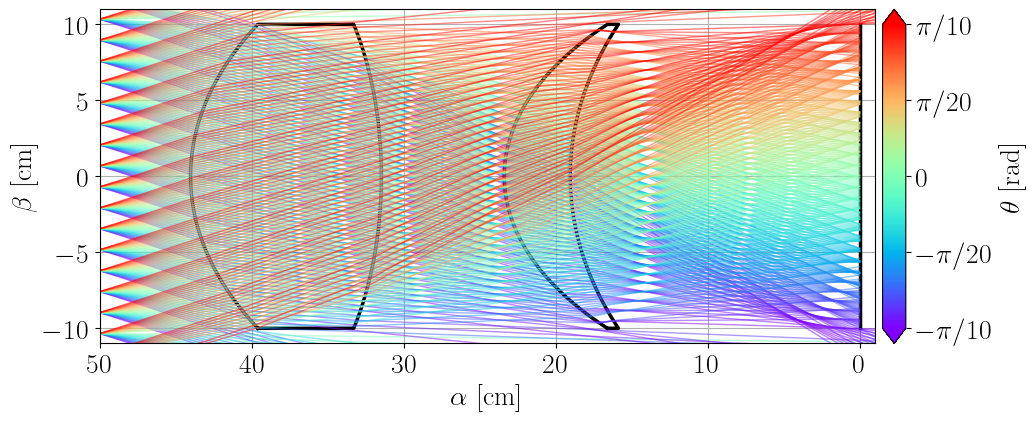

In [55]:
######################################################
###############     USER VARIABLES     ###############
######################################################
verbose = True
plotLenses = True
saveFrames = False
# lens_parameters = [ 
#                     [ ( -40.0, 26.0, -10, 10 ), 7.5, 1.98, (  45.0, 25.0, -10, 10 ), -30 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
#                     [ ( 10.0, 26.0, -10, 10 ), 2  , 1.98, (  25.0, 25.0, -10, 10 ), -24.4 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
#                     [ ( 1e-5, 10, 0, -10, 10 ), 1.69, [ -100, 100 ] ]                     # Final Surface: (r_x, r_y, x, y_min, y_max), n, [y_min, y_max]
# ]

lens_parameterss = [[[(-30.0687810097708, 15.802738144936738, -10, 10), 4.3382303630830705, 1.98, (-39.02710551853179, 25.329948525532547, -10, 10), -21.214101936012206],
 [(-38.12700978510308, 21.387714391677214, -10, 10), 12.558474124579016, 1.98, (8.311193302575996, 16.004035474931783, -10, 10), -37.75034098092813],
 [(1e-05, 10, 0, -10, 10), 1.69, [-100, 100]]]]
p_values = [0]
back_plane_pointss = []

# lens_parameterss = best_lens_parameters[4:5]
# p_values = best_p_values[4:5]
# lens_parameterss = best_lens_parameters[:1]
# p_values = best_p_values[:1]
# lens_parameterss = best_lens_parameters[:10]
# p_values = best_p_values[:10]
# back_plane_pointss = []

# theta_lim = [ -math.pi/10, math.pi/10, 20 ] # min, max, nPoints
theta_lim = [ -math.pi/10, math.pi/10, 30 ] # min, max, nPoints
y_lim     = [ -20       ,        20, 30 ] # min, max, nPoints
# phi_lim   = [ -math.pi/14, math.pi/14, 5 ] # min, max, nPoints
r         = -50

singleRayAnimation = False
nFrames = theta_lim[2]*y_lim[2]
nPoints = 1000
plotName = 'DPSDtestLens'
nFrames_save = [274,286,304,140]
rayThickness = 1
rayAlpha = 0.5
lensColor = 'black' #'lightseagreen'
lensAlpha = 1
rayColors = cm.rainbow(np.linspace(0, 1, theta_lim[-1]))

#######################################################
###############     PLOTTING SCRIPT     ###############
#######################################################

for p_value, lens_parameters in zip(p_values, lens_parameterss):
    surfaces = []
    lenses   = []
    for nLens in range(len(lens_parameters)):
        if nLens != len(lens_parameters)-1:
            surfaces.append(surface(lens_parameters[nLens][0][0],lens_parameters[nLens][0][1],
                                    lens_parameters[nLens][4] - lens_parameters[nLens][0][0] - lens_parameters[nLens][1]/2,
                                    lens_parameters[nLens][0][2],lens_parameters[nLens][0][3],verbose=verbose))
            surfaces.append(surface(lens_parameters[nLens][3][0],lens_parameters[nLens][3][1],
                                    lens_parameters[nLens][4] - lens_parameters[nLens][3][0] + lens_parameters[nLens][1]/2,
                                    lens_parameters[nLens][3][2],lens_parameters[nLens][3][3],verbose=verbose))
            lenses.append(lens(surfaces[-2],surfaces[-1],lens_parameters[nLens][2],verbose)) 
        else:
            surfaces.append(surface(lens_parameters[nLens][0][0],lens_parameters[nLens][0][1],lens_parameters[nLens][0][2],
                                    lens_parameters[nLens][0][3],lens_parameters[nLens][0][4],verbose=verbose))
    OS = opticalSystem(lenses,surfaces[-1],lens_parameters[-1][1],verbose)

    mpl.rc('font', **{'family' : 'serif', 'size' : 20 })
    mpl.rcParams['mathtext.fontset'] = 'cm'
    mpl.rcParams['legend.fontsize' ] = 1

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim(-50,1)
    # ax.set_ylim(-1.4, 1.4)
    # thickness = 2
    # ax.spines['left'].set_linewidth(thickness)
    # ax.spines['bottom'].set_linewidth(thickness)
    # ax.spines['right'].set_linewidth(thickness)
    # ax.spines['top'].set_linewidth(thickness)
    ax.grid()
    ax.set_aspect('equal')
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.set_yticklabels(['$-10$', '$-5$', '$0$','$5$', '$10$'])
    ax.set_xticks([-0, -10, -20, -30, -40, -50])
    ax.set_xticklabels(['$0$','$10$','$20$','$30$','$40$','$50$'])

    if plotLenses: surfaces_points = OS.get_points_lenses  (nPoints)
    else         : surfaces_points = OS.get_points_surfaces(nPoints)
    surfaces_plot = []
    rays_plot     = []
    backPlanePoints = []
    if not singleRayAnimation:
        for nTheta in range(theta_lim[2]):
            rays_plot.append([])
            for nY in range(y_lim[2]):
                rays_plot[nTheta].append([])
    if plotLenses:
        for nLens in range(len(lenses)+1):
            surfaces_plot.append(ax.plot([x for x,y in surfaces_points[nLens]], [y for x,y in surfaces_points[nLens]], color=lensColor, linewidth=2.5, alpha=lensAlpha)[0])
    for nSurface in range(len(surfaces)):
        if not plotLenses: surfaces_plot.append(ax.plot([x for x,y in surfaces_points[nSurface]], [y for x,y in surfaces_points[nSurface]], color=lensColor, linewidth=2.5)[0])
        if nSurface < len(surfaces):
            if not singleRayAnimation:
                for nRays in range(len(rays_plot)):
                    for ray in rays_plot[nRays]:
                        ray.append(ax.plot([],[],linewidth=rayThickness,color=rayColors[nRays],alpha=rayAlpha)[0])
            else:
                rays_plot.append(ax.plot([],[],color='indianred',linewidth=rayThickness,alpha=rayAlpha)[0])
            
    if singleRayAnimation:
        def updateFrame(nFrame):
            nFrame_theta = nFrame // y_lim[2]
            nFrame_y     = nFrame - nFrame_theta * y_lim[2]

            theta      = theta_lim[0] + ( theta_lim[1] - theta_lim[0] ) / (theta_lim[2]-1) * nFrame_theta
            y          = y_lim[0] + (y_lim[1] - y_lim[0])/(y_lim[2]-1)*nFrame_y
            OR         = opticalRay(r,y,theta)
            RP         = rayPropagator(OS,OR,lens_parameters[-1][2])  
            points_ray = RP.propagateRay()
            points_ray_formatted = []
            for nPoint in range(len(points_ray)-1):
                points_ray_formatted.append(([points_ray[nPoint].x,points_ray[nPoint+1].x],[points_ray[nPoint].y,points_ray[nPoint+1].y]))
            
            for nRay in range(len(rays_plot)):
                rays_plot[nRay].set_data(points_ray_formatted[nRay][0], points_ray_formatted[nRay][1])

            if saveFrames and nFrame in nFrames_save:
                plt.savefig('Frames/'+plotName+'-'+str(nFrame)+'.pdf',bbox_inches='tight')

            return surfaces_plot[0], rays_plot[0]

        animation = FuncAnimation(fig, updateFrame, frames=nFrames, interval=1, blit=True)

        animation.save(plotName+'.gif', writer='pillow')
    else:
        for nFrame in range(nFrames):
            nFrame_theta = nFrame // y_lim[2]
            nFrame_y     = nFrame - nFrame_theta * y_lim[2]

            theta      = theta_lim[0] + ( theta_lim[1] - theta_lim[0] ) / (theta_lim[2]-1) * nFrame_theta
            y          = y_lim[0] + (y_lim[1] - y_lim[0])/(y_lim[2]-1)*nFrame_y
            OR         = opticalRay(r,y,theta)
            RP         = rayPropagator(OS,OR,lens_parameters[-1][2])  
            points_ray = RP.propagateRay()
            points_ray_formatted = []
            for nPoint in range(len(points_ray)-1):
                points_ray_formatted.append(([points_ray[nPoint].x,points_ray[nPoint+1].x],[points_ray[nPoint].y,points_ray[nPoint+1].y]))
            backPlanePoints.append((theta, points_ray_formatted[-1][1][1]))
            # print(points_ray_formatted)

            for nRay in range(len(rays_plot[nFrame_theta][nFrame_y])):
                rays_plot[nFrame_theta][nFrame_y][nRay].set_data(points_ray_formatted[nRay][0], points_ray_formatted[nRay][1])
    
    # ax.set_title(f"p-value = {p_value}")
    plt.ylabel(r'$\beta$ [cm]')
    plt.xlabel(r'$\alpha$ [cm]')
    # Add color bar
    # Add color bar
    scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=theta_lim[0], vmax=theta_lim[1]), cmap=cm.rainbow)
    cax = ax.inset_axes([1.01, 0, 0.03, 1])  # Adjust the position and size as needed
    cb = fig.colorbar(scalar_mappable, cax=cax, label=r'$\theta$ [rad]', extend='both')
    cb.set_ticks([-math.pi/10, -math.pi/20, 0, math.pi/20, math.pi/10])
    cb.set_ticklabels(['$-\pi/10$', '$-\pi/20$', '$0$', '$\pi/20$', '$\pi/10$'])
    fig.savefig('../figures/DSPDtestLens.pdf',bbox_inches='tight')
    fig.show()
    print('p-value =', p_value)
    print('lens_parameters =', lens_parameters)
    print()
    back_plane_pointss.append(backPlanePoints)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58904/3402931763.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', len(unique_x_values))


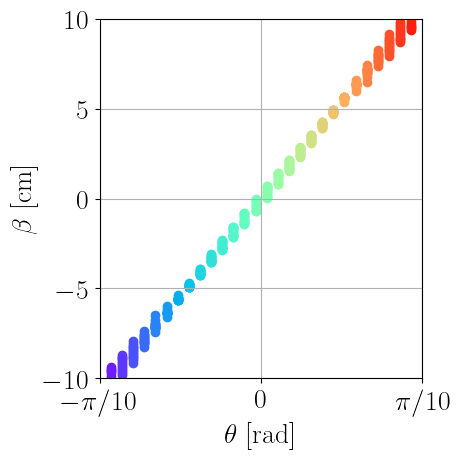

In [56]:
for p_value, backPlanePoints in zip(p_values, back_plane_pointss):
    # Create a new figure
    plt.figure(figsize=(5, 5))
    plt.xlabel(r'$\theta$ [rad]')
    plt.ylabel(r'$\beta$ [cm]')
    # plt.title('p-value = ' + str(p_value))

    # Get unique x values
    unique_x_values = sorted(set([point[0] * 180 / math.pi for point in backPlanePoints]))
    cmap = cm.get_cmap('rainbow', len(unique_x_values))

    # Plot each point with the corresponding color
    for i, point in enumerate(backPlanePoints):
        x = point[0] * 180 / math.pi
        y = point[1]
        color = cmap(unique_x_values.index(x))
        plt.scatter(x/180*np.pi, y, marker='o', color=color)

    # Show the plot
    plt.grid()
    plt.ylim(-10, 10)
    plt.xticks([-math.pi/10, 0, math.pi/10], ['$-\pi/10$', '$0$', '$\pi/10$'])
    plt.xlim(-math.pi/10, math.pi/10)
    plt.tight_layout()
    plt.savefig('../figures/points.pdf',bbox_inches='tight')
    plt.show()


/opt/homebrew/anaconda3/envs/Python_3_11_5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/Python_3_11_5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/Python_3_11_5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


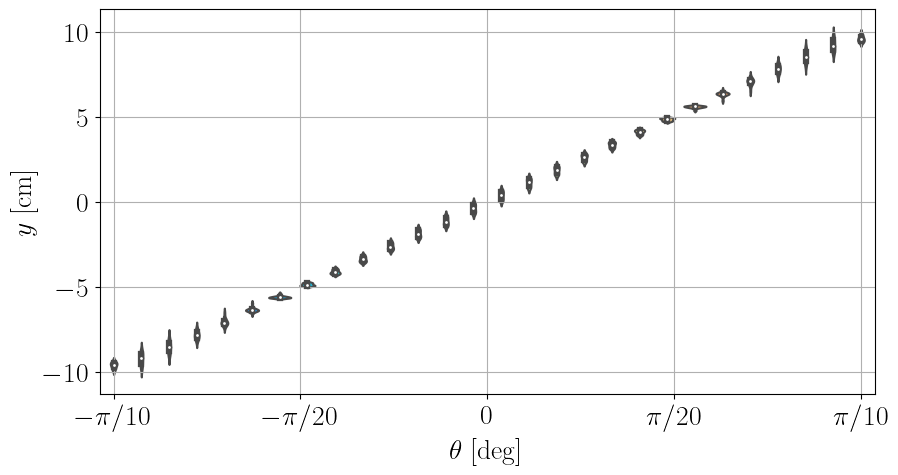

p-value = 0
nBackPlanePoints = 382


In [57]:
for p_value, backPlanePoints in zip(p_values, back_plane_pointss):
    theta_values = []
    y_values     = []
    for theta,y in backPlanePoints:
        if abs(y) <= 90:
            theta_values.append(theta)
            y_values    .append(y)
    data = pd.DataFrame({"theta": theta_values, "y": y_values})
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.violinplot(data=data,x='theta',y='y', palette='rainbow')
    ax.set_xlabel(r'$\theta$ $\mathrm{[deg]}$')
    ax.set_ylabel(r'$y$ $\mathrm{[cm]}$')
    # ax.set_ylim(-5, 5)
    unique_thetas = sorted(set(theta_values))
    # ax.set_xticks(range(len(unique_thetas)))
    # formatted_labels = ["{:.1f}".format(theta * 180 / math.pi) for theta in unique_thetas]
    # ax.set_xticklabels(formatted_labels)
    ax.set_xticks(np.linspace(0, len(unique_thetas)-1, 5))
    ax.set_xticklabels(['$-\pi/10$', '$-\pi/20$', '$0$', '$\pi/20$', '$\pi/10$'])
    ax.grid()
    # ax.title.set_text(f"p-value = {p_value}")
    fig.savefig('../figures/PDF.pdf',bbox_inches='tight')
    plt.show()
    print('p-value =', p_value)
    print('nBackPlanePoints =', len(theta_values))

Theta: -0.29249310912732557, Standard Deviation: 0.1821417869194854
Theta: -0.2708269528956718, Standard Deviation: 0.3730895947170159
Theta: -0.24916079666401808, Standard Deviation: 0.3498825500088029
Theta: -0.22749464043236434, Standard Deviation: 0.24901238823173466
Theta: -0.2058284842007106, Standard Deviation: 0.21881219852582506
Theta: -0.18416232796905682, Standard Deviation: 0.1353334700101183
Theta: -0.16249617173740308, Standard Deviation: 0.07229606916656642
Theta: -0.14083001550574933, Standard Deviation: 0.08141634662279162
Theta: -0.11916385927409559, Standard Deviation: 0.1214206462248619
Theta: -0.09749770304244185, Standard Deviation: 0.15549001716907151
Theta: -0.0758315468107881, Standard Deviation: 0.18591650712612554
Theta: -0.05416539057913433, Standard Deviation: 0.21081756257035716
Theta: -0.03249923434748059, Standard Deviation: 0.22943542080558219
Theta: -0.010833078115826844, Standard Deviation: 0.23924037938155326
Theta: 0.0108330781158269, Standard Devia

/opt/homebrew/anaconda3/envs/Python_3_11_5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/Python_3_11_5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/Python_3_11_5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


p-value = 0
nBackPlanePoints = 382


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58904/1288026253.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


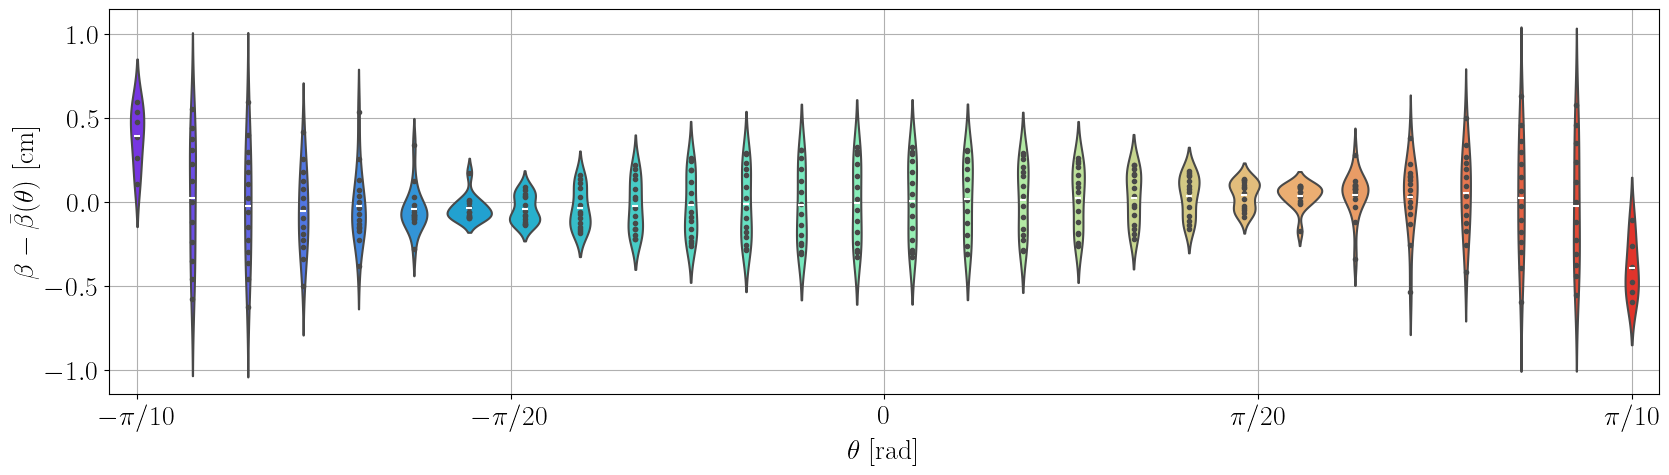

In [65]:
for p_value, backPlanePoints in zip(p_values, back_plane_pointss):
    theta_values = []
    y_values     = []
    for theta,y in backPlanePoints:
        if abs(y) <= 90:
            theta_values.append(theta)
            y_values    .append(y)
    data = pd.DataFrame({"theta": theta_values, "y": y_values})

    # Subtract the average y value from the actual y value
    # data['y'] = data.apply(lambda row: row['y'] - average_y_values[row['theta']], axis=1)
    slopes = [
    38.27002289,
    34.14230382,
    30.37080385,
    28.71807624]
    slope = slopes[1]
    data['y'] = data.apply(lambda row: row['y'] - slope*row['theta'], axis=1)
    average_y_values = data.groupby('theta')['y'].mean()
    # Calculate the standard deviation of each theta value in average_y_values
    std_values = data.groupby('theta')['y'].std()

    # Print the standard deviation of each theta value
    for theta, std in std_values.items():
        print(f"Theta: {theta}, Standard Deviation: {std}")
    unique_thetas = sorted(set(theta_values))
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.violinplot(data=data,x='theta',y='y', palette='rainbow', ax=ax, inner="point")
    ax.scatter(np.linspace(0, len(unique_thetas)-1, len(unique_thetas)), average_y_values, color='white', s=22, marker='_')
    ax.set_xlabel(r'$\theta$ [rad]')
    ax.set_ylabel(r'$\beta-\bar{\beta}(\theta)$ [cm]')
    # ax.set_ylim(-5, 5)
    # ax.set_xticks(range(len(unique_thetas)))
    # formatted_labels = ["{:.1f}".format(theta * 180 / math.pi) for theta in unique_thetas]
    # ax.set_xticklabels(formatted_labels)
    # ax.set_xlim(-math.pi/10, math.pi/10)
    # ax.set_xticks([-math.pi/10, -math.pi/20, 0, math.pi/20, math.pi/10])
    ax.set_xticks(np.linspace(0, len(unique_thetas)-1, 5))
    ax.set_xticklabels(['$-\pi/10$', '$-\pi/20$', '$0$', '$\pi/20$', '$\pi/10$'])
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xlim(0-.5, len(unique_thetas)-1+.5)
    # ax.title.set_text(f"p-value = {p_value}")
    fig.savefig('../figures/PDF_deviation.pdf',bbox_inches='tight')
    fig.show()
    print('p-value =', p_value)
    print('nBackPlanePoints =', len(theta_values))

In [51]:
def func(x, a, b):
    return a * x + b

backPlanePoints = np.array(backPlanePoints)
filtered_backPlanePoints = backPlanePoints[abs(backPlanePoints[:, 1]) <= 99]
params, _ = curve_fit(func, filtered_backPlanePoints[:, 0], filtered_backPlanePoints[:, 1])

print(params)

[ 3.41423038e+01 -5.40303652e-09]


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_58904/1992144044.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


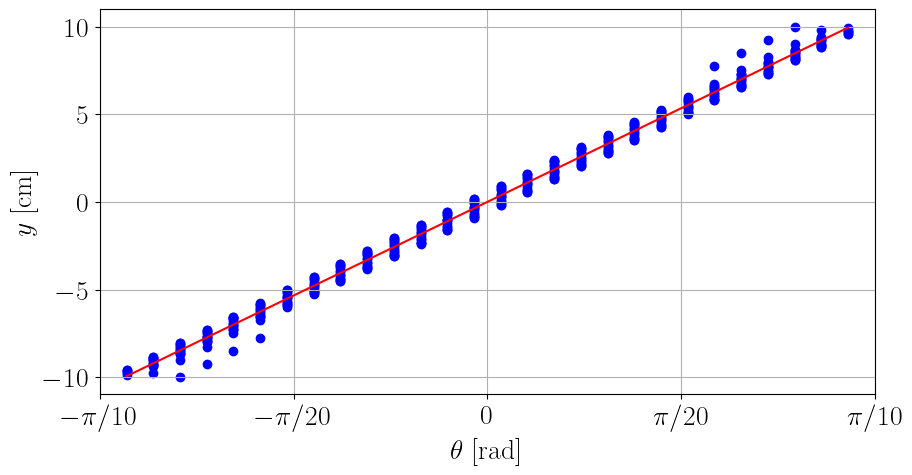

In [19]:
x_values = filtered_backPlanePoints[:, 0]
predictions = func(x_values, *params)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x_values, filtered_backPlanePoints[:, 1], label='Data', color='blue')
line_equation = fr"$y = {params[0]:.2f} \theta$"
ax.plot(x_values, predictions, color='red', label=line_equation)
ax.set_xlabel(r'$\theta$ $\mathrm{[rad]}$')
ax.set_ylabel(r'$y$ $\mathrm{[cm]}$')
ax.set_xlim(-math.pi/10, math.pi/10)
ax.set_xticks([-math.pi/10, -math.pi/20, 0, math.pi/20, math.pi/10])
ax.set_xticklabels(['$-\pi/10$', '$-\pi/20$', '$0$', '$\pi/20$', '$\pi/10$'])
ax.grid()
# ax.legend(loc='lower right')
fig.show()